<a href="https://colab.research.google.com/github/darvesh-sd/Copy-of-TPSession1.ipynb/blob/main/Copy_of_TPSession2_Darvesh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Mount Google Drive**

- from google.colab import drive imports the Colab-specific drive module to enable mounting.
- drive.mount('/content/drive') mounts Google Drive to Colab. Once mounted, files in Google Drive can be accessed via /content/drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

# Load the CSV file from Google Drive
df = pd.read_csv('/content/drive/MyDrive/car_data_template.csv')


**Data Upload**

- files.upload() opens a dialog box to let you choose a CSV file to upload from your local machine.
- next(iter(uploaded)) grabs the filename of the uploaded file.
- *pd*.read_csv() loads the CSV file into a Pandas DataFrame.

In [ ]:
import pandas as pd
from google.colab import files

uploaded = files.upload()
df = pd.read_csv(next(iter(uploaded)))


**Check data structure uploaded**

- df.info() provides an overview of the dataset, including data types, column names, and memory usage.
- df.head() displays the first few rows to give a sense of the data layout.
- df.isnull().sum() counts the missing values in each column to help identify columns that need data cleaning.

In [ ]:
print("Dataset Overview:")
print(df.info())
print("\nFirst few rows:")
print(df.head())
print("\nSummary of Missing Values:")
print(df.isnull().sum())


Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   brand         50 non-null     object 
 1   model         50 non-null     object 
 2   year          50 non-null     int64  
 3   price         50 non-null     float64
 4   mileage       50 non-null     float64
 5   fuel_type     50 non-null     object 
 6   transmission  50 non-null     object 
 7   color         50 non-null     object 
 8   condition     50 non-null     object 
dtypes: float64(2), int64(1), object(6)
memory usage: 3.6+ KB
None

First few rows:
       brand    model  year     price   mileage fuel_type    transmission  \
0     Toyota  Mustang  2020  35038.08   18663.5    Diesel  Semi-Automatic   
1      Honda   Altima  2015  42172.46  144962.1    Hybrid          Manual   
2    Hyundai  Corolla  2020  47015.44   30219.4  Electric             CVT   
3  Chevrolet   

**Data Cleaning and Preprocessing**

- df.copy() creates a duplicate of the DataFrame to preserve the original data.
- df_clean.drop_duplicates() removes any identical rows in the DataFrame.

This removes duplicate rows and handle missing values using a "smart imputation" approach, filling in missing values differently depending on whether they’re numeric or categorical.

In [ ]:
df_clean = df.copy()
initial_rows = len(df_clean)
df_clean = df_clean.drop_duplicates()
print(f"Duplicates removed: {initial_rows - len(df_clean)} rows")


Duplicates removed: 0 rows


Defining and applying a function for missing values

In [ ]:
def smart_impute(df, column):
    if df[column].dtype in ['int64', 'float64']:
        return df[column].fillna(df[column].median()) if 'brand' not in df.columns else df.groupby('brand')[column].transform(lambda x: x.fillna(x.median()))
    else:
        return df[column].fillna(df[column].mode()[0])


**Data Type Optimization and String Cleaning**

- Function Details:
 - clean_string() is used to remove whitespace and convert text to lowercase for consistent string formatting.

In [ ]:
def clean_string(value):
    if pd.isna(value):
        return value
    return str(value).strip().lower()


- The loop checks each column’s data type.
- If the column is a string, clean_string() is applied.
- If numeric, pd.to_numeric() attempts conversion to an optimized format.

In [ ]:
for column in df_clean.columns:
    if df_clean[column].dtype == 'object':  # Clean string columns
        df_clean[column] = df_clean[column].apply(clean_string)
    elif df_clean[column].dtype in ['int64', 'float64']:  # Optimize numeric columns
        df_clean[column] = pd.to_numeric(df_clean[column], errors='coerce')


**Advanced Feature Engineering**

- new insights based on the existing data. Here, we add columns like vehicle age, price per mile, and brand popularity.

In [ ]:
from datetime import datetime
current_year = datetime.now().year


- The above retrieves the current year, which we’ll use to calculate the vehicle’s age. It is calculated by subtracting each car’s year from the current year.

In [ ]:
# Calculate vehicle age based on the 'year' column
if 'year' in df_clean.columns:
    df_clean['vehicle_age'] = current_year - df_clean['year']


- price_per_mile is created by dividing the price by mileage. .clip(lower=1) prevents division by zero.

In [ ]:
# Calculate price per mile for value assessment if mileage and price are available
if all(col in df_clean.columns for col in ['price', 'mileage']):
    df_clean['price_per_mile'] = df_clean['price'] / df_clean['mileage'].clip(lower=1)


- brand_popularity shows each brand’s frequency as a fraction of the total dataset.
- value_counts(normalize=True) gives each brand’s percentage in the dataset.

In [ ]:
# Create a popularity index for each brand based on frequency in the dataset
if 'brand' in df_clean.columns:
    brand_counts = df_clean['brand'].value_counts(normalize=True)
    df_clean['brand_popularity'] = df_clean['brand'].map(brand_counts)


**Outlier Detection and Treatment**

Identification outliers in numeric columns using the Interquartile Range (IQR) method and then clips those outliers to reasonable limits.

- detect_outliers() calculates the IQR to find lower and upper bounds for outliers.

In [ ]:
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound, upper_bound = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    return lower_bound, upper_bound


Use of these bounds to "clip" (limit) values in numeric columns. This loop applies the bounds to each numeric column, setting any outliers to the upper or lower limit.

In [ ]:
for column in df_clean.select_dtypes(include=['float64', 'int64']).columns:
    if column != 'year':
        lower, upper = detect_outliers(df_clean, column)
        df_clean[column] = df_clean[column].clip(lower, upper)


**Data Visualization and Analysis**

This section visualizes key patterns in the dataset, using subplots for better organization and a variety of plot types.

- plt.style.use('seaborn-darkgrid') sets the plotting style.
- sns.set_palette("muted") defines a color palette.
- plt.figure(figsize=(20, 15)) creates a large plotting area.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style and figure size
plt.style.use('seaborn-darkgrid')
sns.set_palette("deep")
plt.figure(figsize=(20, 18))


<ipython-input-23-8c9a90328dc0>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


<Figure size 2000x1800 with 0 Axes>

<Figure size 2000x1800 with 0 Axes>

sns.histplot() shows the distribution of prices.

Text(0, 0.5, 'Count')

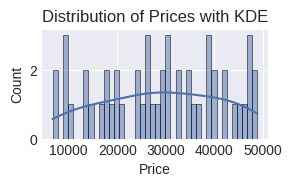

In [ ]:
# 1. Price Distribution with KDE (Kernel Density Estimate)
plt.subplot(3, 2, 1)
sns.histplot(data=df_clean, x='price', bins=40, kde=True)
plt.title('Distribution of Prices with KDE')
plt.xlabel('Price')
plt.ylabel('Count')


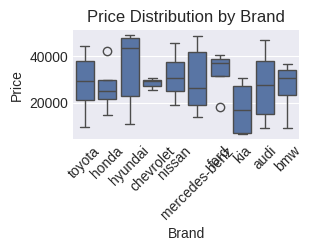

In [ ]:
# 2. Price by Brand Boxplot - Show distribution of price for each brand
if 'brand' in df_clean.columns:
    plt.subplot(3, 2, 2)
    sns.boxplot(data=df_clean, x='brand', y='price')
    plt.xticks(rotation=45)
    plt.title('Price Distribution by Brand')
    plt.xlabel('Brand')
    plt.ylabel('Price')


Text(55.58333333333332, 0.5, 'Numerical Features')

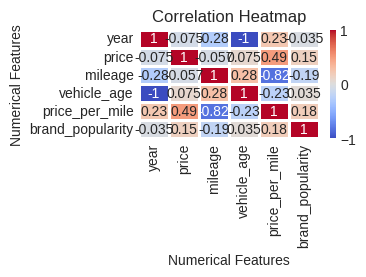

In [ ]:
# 3. Correlation Heatmap - For all numerical columns
plt.subplot(3, 2, 3)
numeric_cols = df_clean.select_dtypes(include=['float64', 'int64']).columns
correlation = df_clean[numeric_cols].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0, linewidths=1)
plt.title('Correlation Heatmap')
plt.xlabel('Numerical Features')
plt.ylabel('Numerical Features')


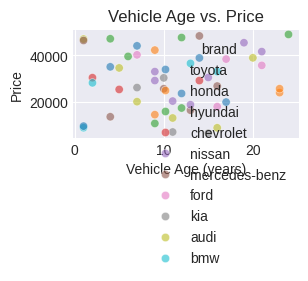

In [ ]:
# 4. Vehicle Age vs. Price Scatter Plot - Analyze the impact of age on price
if 'vehicle_age' in df_clean.columns and 'price' in df_clean.columns:
    plt.subplot(3, 2, 4)
    sns.scatterplot(data=df_clean, x='vehicle_age', y='price', hue='brand', palette='tab10', alpha=0.6)
    plt.title('Vehicle Age vs. Price')
    plt.xlabel('Vehicle Age (years)')
    plt.ylabel('Price')

<ipython-input-35-9814d7542961>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


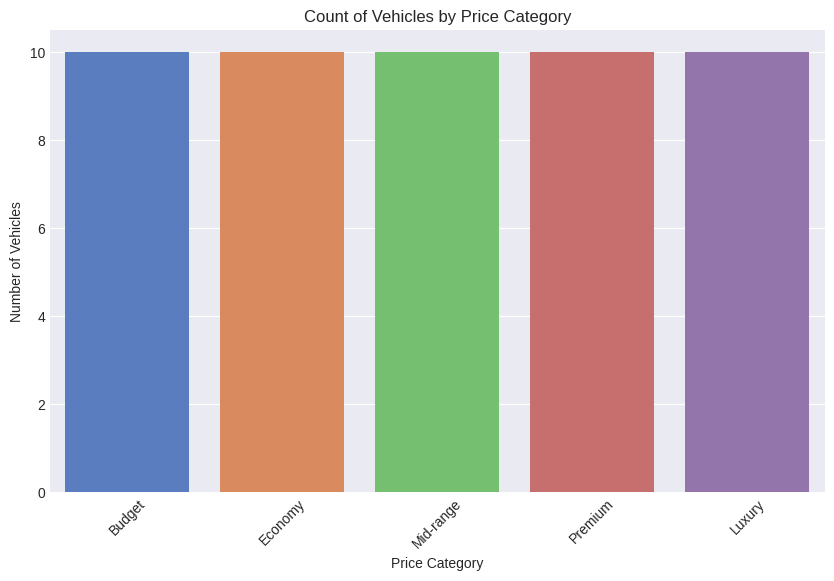

In [ ]:
# 5. Price Category Count Plot - Shows the distribution of vehicles by price category

# Step 1: Ensure 'price_category' column exists and is populated
if 'price' in df_clean.columns:
    if 'price_category' not in df_clean.columns or df_clean['price_category'].isnull().any():
        # Create 'price_category' based on quantiles of 'price'
        df_clean['price_category'] = pd.qcut(
            df_clean['price'].fillna(df_clean['price'].median()),  # Handle missing prices by filling with median
            q=5,
            labels=['Budget', 'Economy', 'Mid-range', 'Premium', 'Luxury']
        )
        print("Price categories created successfully.")

# Step 2: Plot the distribution of vehicles by price category
if 'price_category' in df_clean.columns:
    plt.figure(figsize=(10, 6))  # Adjust figure size for clarity
    sns.countplot(
        data=df_clean,
        x='price_category',
        palette='muted',
        order=['Budget', 'Economy', 'Mid-range', 'Premium', 'Luxury']
    )
    plt.title('Count of Vehicles by Price Category')
    plt.xlabel('Price Category')
    plt.ylabel('Number of Vehicles')
    plt.xticks(rotation=45)  # Rotate x labels for better readability
    plt.show()
else:
    print("The 'price_category' column is missing and could not be created.")



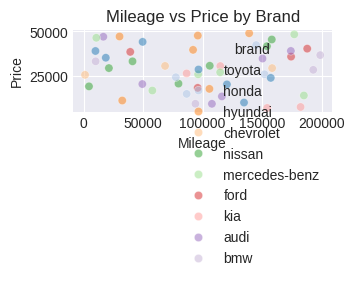

In [ ]:
# 6. Mileage vs Price Relationship - Mileage trend by price range
if all(col in df_clean.columns for col in ['mileage', 'price']):
    plt.subplot(3, 2, 6)
    sns.scatterplot(data=df_clean, x='mileage', y='price', hue='brand', palette='tab20', alpha=0.5)
    plt.title('Mileage vs Price by Brand')
    plt.xlabel('Mileage')
    plt.ylabel('Price')

plt.tight_layout()
plt.show()

**Summary and Export Cleaned Data**

Here it saves the cleaned and processed data for future use.

- df_clean.describe() gives summary statistics for the cleaned data.

In [ ]:
print("\nSummary Statistics:")
print(df_clean.describe().round(2))



Summary Statistics:
          year     price    mileage  vehicle_age  price_per_mile  \
count    50.00     50.00      50.00        50.00           50.00   
mean   2012.84  28846.93  100532.72        11.16            0.40   
std       6.29  12449.03   59398.13         6.29            0.32   
min    2000.00   6695.16    1244.50         1.00            0.04   
25%    2008.25  19155.93   49410.38         7.00            0.17   
50%    2013.00  29177.66  100969.25        11.00            0.27   
75%    2017.00  38866.95  153528.62        15.75            0.48   
max    2023.00  48856.04  198776.90        24.00            0.95   

       brand_popularity  
count             50.00  
mean               0.11  
std                0.02  
min                0.06  
25%                0.08  
50%                0.12  
75%                0.12  
max                0.14  


df_clean.to_csv() saves the cleaned data to a CSV file, so it can be reused without re-running the code.

In [ ]:
cleaned_filename = 'cars_cleaned.csv'
df_clean.to_csv(cleaned_filename, index=False)
